In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from cvx_portfolio.costs import TcostModel
from cvx_portfolio.returns import AlphaSource
from cvx_portfolio.simulator import MarketSimulator
from cvx_portfolio.policies import SinglePeriodOpt, FixedTrade, MultiPeriodOpt, SellAll
from cvx_portfolio.data import generate_alpha_signal, series_factor_model_covariance
from cvx_portfolio.risks import EmpSigma, FactorModelSigma
from cvx_portfolio.constraints import LeverageLimit  


plotdir = '../portfolio/plots/'
datadir= '../equity_data_tool/'

## Download data using ee103 code (to be integrated) 

In [2]:
sigmas=pd.read_csv(datadir+'sigmas.txt',index_col=0,parse_dates=[0])
returns=pd.read_csv(datadir+'returns.txt',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.txt',index_col=0,parse_dates=[0])

In [3]:
exposures_pan, factor_sigma_pan, idyos_df = series_factor_model_covariance(returns, 
                                                                           variance_explained=.6,
                                                                           freq='MS',
                                    lookback_periods = 12)
risk_model = FactorModelSigma(exposures_pan, factor_sigma_pan, idyos_df)

In [5]:
np.random.seed(1)
alpha_signal=generate_alpha_signal(real_returns=returns, IC=0.01, type_noise='OU')
alpha_signal.USDOLLAR = returns.USDOLLAR
alpha_model = AlphaSource(alpha_signal)

### Transaction costs model

In [6]:
del volumes['USDOLLAR']
del sigmas['USDOLLAR']

spread = pd.DataFrame(data=5e-4, index=volumes.index, columns=volumes.columns)
nonlin_coeff = pd.DataFrame(data=1, index=volumes.index, columns=volumes.columns)
simulated_tcost = TcostModel(volumes, sigmas, spread, nonlin_coeff, cash_key='USDOLLAR')

## Market simulator 

In [7]:
simulator = MarketSimulator(returns, volumes, [simulated_tcost], cash_key='USDOLLAR')

## Portfolio

In [8]:
p = pd.Series(index=returns.columns, data=1)/len(returns.columns)
weights=p/sum(p)
p_0 = 1E10*p

## Policy

In [9]:
# larger than .4 we almost don't trade.
gamma_tcost = 50.
gamma_risk = 100.
policy_spo=SinglePeriodOpt(alpha_model, [gamma_risk*risk_model, gamma_tcost*simulated_tcost], [LeverageLimit(3)])

In [10]:
T=len(returns[(returns.index>='2012-12-01')&(returns.index<='2012-12-31')])
z_target = -(p_0/(T+2))[:-1]
z_target['USDOLLAR']=-sum(z_target)
policy_fixed_trade = FixedTrade(tradevec=z_target)

## Simulations

In [11]:
def concat_results(first, second):
    first.h_next =  pd.concat([first.h_next, second.h_next])
    first.u =  pd.concat([first.u,second.u])
    first.simulator_TcostModel = pd.concat([first.simulator_TcostModel,
                                                second.simulator_TcostModel])
    return first

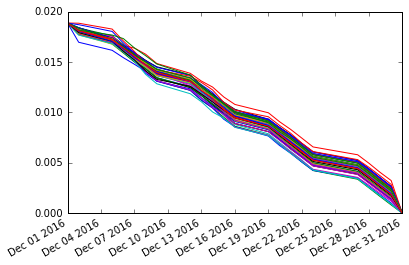

In [12]:
day_before = '2016-12-29'
results_fixed_first=simulator.run_backtest(p_0, start_time = '2016-12-01', end_time='2016-12-29', 
                                              policy=policy_fixed_trade)
results_fixed_second = simulator.run_backtest(results_fixed_first.h.ix[-1], 
                                              start_time = '2016-12-30', end_time='2016-12-31', 
                                              policy=SellAll())

results_fixed = concat_results(results_fixed_first, results_fixed_second)

results_fixed.w.ix[:,:-1].plot(legend=False)

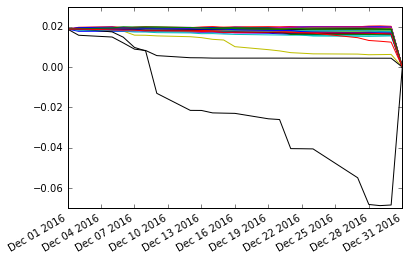

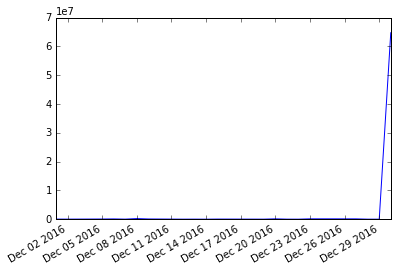

In [13]:
day_before = '2016-12-29'
results_spo_first=simulator.run_backtest(p_0, start_time = '2016-12-01', end_time='2016-12-29', 
                                              policy=policy_spo)
results_spo_second = simulator.run_backtest(results_spo_first.h.ix[-1], start_time = '2016-12-30', end_time='2016-12-31', 
                                              policy=SellAll())

results_spo = concat_results(results_spo_first, results_spo_second)

results_spo.w.ix[:,:-1].plot(legend=False)
plt.figure()
results_spo.simulator_TcostModel.sum(1).plot()

### Define MPO policy 

In [74]:
gamma_tcost = 100.
gamma_risk = 50.

target=pd.Series(index=p_0.index, data=0.)
target.USDOLLAR=1.

alpha_model = AlphaSource(alpha_signal, half_life=2)

policy_mpo=MultiPeriodOpt(alpha_model=alpha_model, 
                          costs=[gamma_risk*risk_model, gamma_tcost*simulated_tcost], 
                          constraints=[LeverageLimit(3)],
                          trading_times=list(returns.index[-21:]),
                         lookahead_periods=25,
                         terminal_weights=target)

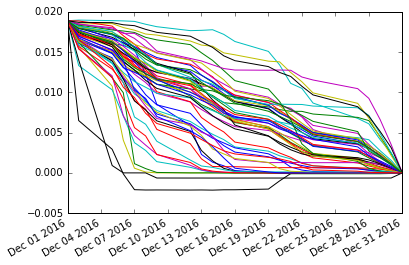

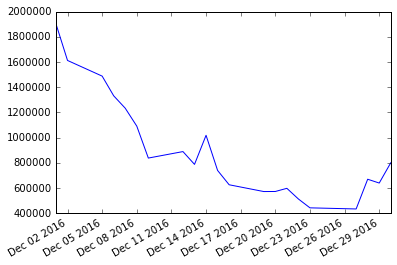

In [75]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")
results_mpo = simulator.run_backtest(p_0, start_time = '2016-12-01', end_time='2016-12-31', 
                                              policy=policy_mpo,
                                    loglevel=logging.INFO)

results_mpo.w.ix[:,:-1].plot(legend=False)
plt.figure()
results_mpo.simulator_TcostModel.sum(1).plot()

In [76]:
row_table=lambda x: {r'$\bar R^\mathrm{p}$':"%.2f%%"%(100*x.mean_return), 
           r'$ \sigma^\mathrm{p}$':"%.2f%%"%(100*x.volatility), 
           'Total t. cost': "%.2f$M"%(x.simulator_TcostModel.sum(1).sum()/1000000)}

results=pd.DataFrame(columns=['$\\bar R^\\mathrm{p}$', '$ \\sigma^\\mathrm{p}$', 'Total t. cost'])
results.loc['Fixed trades',] = pd.Series(row_table(results_fixed))
results.loc['Single period opt.',] = pd.Series(row_table(results_spo))
results.loc['Multi period opt.',] = pd.Series(row_table(results_mpo))
results

,$\bar R^\mathrm{p}$,$ \sigma^\mathrm{p}$,Total t. cost
Fixed trades,13.86%,4.90%,17.85$M
Single period opt.,9.65%,7.83%,65.84$M
Multi period opt.,12.02%,3.26%,18.80$M


In [78]:
print(results.to_latex())

\begin{tabular}{llll}
\toprule
{} & \$\textbackslashbar R\textasciicircum\textbackslashmathrm\{p\}\$ & \$ \textbackslashsigma\textasciicircum\textbackslashmathrm\{p\}\$ & Total t. cost \\
\midrule
Fixed trades       &              13.86\% &                4.90\% &       17.85\$M \\
Single period opt. &               9.65\% &                7.83\% &       65.84\$M \\
Multi period opt.  &              12.02\% &                3.26\% &       18.80\$M \\
\bottomrule
\end{tabular}



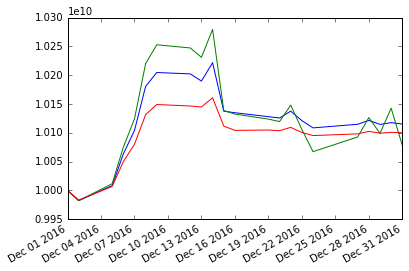

In [79]:
results_fixed.v.plot()
results_spo.v.plot()
results_mpo.v.plot()

### Plot 

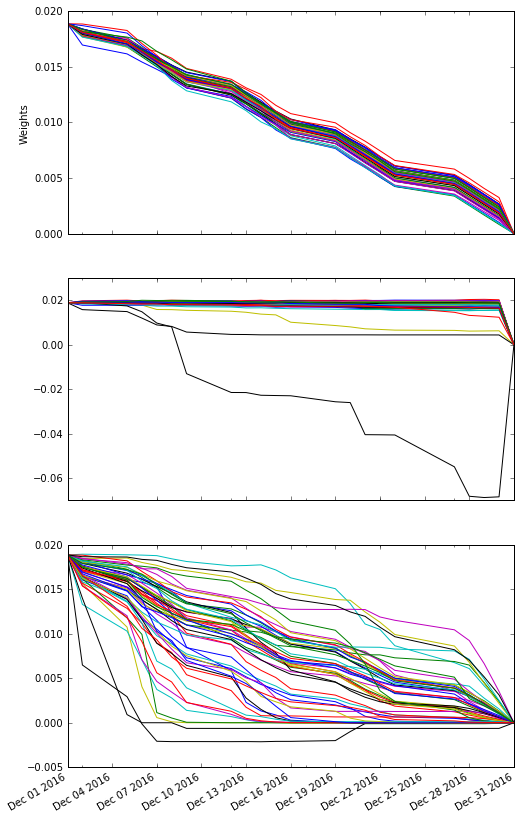

In [94]:
f, axarr = plt.subplots(3, figsize=(8,15),sharex=True)
results_fixed.w.ix[:,:-1].plot(ax=axarr[0], legend=False)
results_spo.w.ix[:,:-1].plot(ax=axarr[1], legend=False)
results_mpo.w.ix[:,:-1].plot(ax=axarr[2], legend=False)
axarr[0].set_ylabel('Weights')
axarr[1].set_ylabel('Weights')
axarr[2].set_ylabel('Weights')
plt.savefig('mpo-weights.png')